In [325]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler

# Set plotting style to seaborn
sns.set(style="whitegrid")

# Give all the plots LaTex font and text    
rc('text', usetex=True)
rc('font', family='serif')

## Read Me

The goal of this notebook is to determine as to what extend the synthetic data generated by the GAN is combarable to real option data.

## Data Preprocessing

As input, we have synthetic data generate by the GAN and actual preprocessed data 

In [326]:
# Read input data to pandas dataframe 
df_synthetic = pd.read_excel('/Users/koensmallegange/Desktop/Research-Practicum/Data/synthetic_gold_lowsamples_7500.xlsx')
df_real = pd.read_excel('/Users/koensmallegange/Desktop/Research-Practicum/Data/FUT_option.xlsx')



### First we preprocess the real data

In [327]:

# Convert to datetime
df_real['date'] = pd.to_datetime(df_real['date'])
df_real['futures_expiration_date'] = pd.to_datetime(df_real['futures_expiration_date'])
df_real['options_expiration_date'] = pd.to_datetime(df_real['options_expiration_date'], errors='coerce')

df_real = df_real[df_real['options_expiration_date'] >= '2019-10-18']
df_real['TTM'] = (df_real['options_expiration_date'] - df_real['date']).dt.days / 365.25

# # Remove zero bid/asks 
# df_real = df_real.drop(df_real[df_real['bid'] == 0].index)
# df_real = df_real.drop(df_real[df_real['ask'] == 0].index)

# Rescale
df_real['futures_close'] = df_real['futures_close']/1000000
df_real['strike'] = df_real['strike']/1000000
df_real['bid'] = df_real['bid']/1000000
df_real['ask'] = df_real['ask']/1000000
df_real['settlement'] = df_real['settlement']/1000000
df_real['vega'] = df_real['vega']/1000000

# Isolate call and put
df_real_call = df_real[df_real['call_put'] == 'C'].copy()
df_real_put = df_real[df_real['call_put'] == 'P'].copy()

# Sort by date
df_real_call.sort_values('date', inplace=True)
df_real_put.sort_values('date', inplace=True)

# Drop non-numeric columns if there are any
df_real = df_real_call.select_dtypes(include=[np.number])
df_real = df_real.drop(['delta', 'vega', 'gamma', 'theta'], axis=1)

# Filter out rows with IV > 1000
mask = df_real['iv'] > 1000
df_real = df_real[~mask]

# Print some stats about the data 
print(len(df_synthetic))
print(len(df_real))

5211
5211


In [328]:
df_real

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,TTM
0,1483.500000,1275.0,0.0,0.0,208.600006,0.651953,0.651953,0,0,0.008214
7306,1523.199951,1240.0,0.0,0.0,293.299988,0.155148,0.155148,0,0,1.533196
7304,1523.199951,1230.0,0.0,0.0,302.200012,0.157257,0.157257,0,0,1.533196
7302,1523.199951,1225.0,0.0,0.0,306.600006,0.158140,0.158140,0,0,1.533196
7300,1523.199951,1220.0,0.0,0.0,311.100006,0.159270,0.159270,0,0,1.533196
...,...,...,...,...,...,...,...,...,...,...
3810,1504.900024,1095.0,0.0,0.0,409.899994,0.236580,0.236580,0,0,0.695414
3808,1504.900024,1090.0,0.0,0.0,414.899994,0.239999,0.239999,0,0,0.695414
3806,1504.900024,1085.0,0.0,0.0,419.899994,0.243437,0.243437,0,0,0.695414
3842,1504.900024,1175.0,0.0,0.0,329.899994,0.183995,0.183995,0,0,0.695414


In [329]:
df_synthetic['Moneyness'] = df_synthetic['strike']/df_synthetic['futures_close']
df_synthetic

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,TTM,Moneyness
0,1517.619552,1510.182646,0.000000,0.000000,95.183331,0.147073,0.147068,0.000000,0.004592,1.265260,0.995100
1,1516.230006,1672.302476,0.000000,0.000000,55.101157,0.175533,0.175638,0.000000,0.011020,1.199631,1.102935
2,1565.574879,1557.037883,0.000000,0.000000,174.598956,0.152489,0.153800,0.000000,0.000000,3.888947,0.994547
3,1540.735443,1603.805245,0.000000,0.000000,120.716011,0.164023,0.163870,0.000000,0.000000,2.495479,1.040935
4,1544.400067,1413.749221,0.000000,0.000000,215.784677,0.150272,0.149954,0.000000,0.000000,2.710377,0.915403
...,...,...,...,...,...,...,...,...,...,...,...
5206,1520.792509,1456.836709,0.000000,0.000000,126.576503,0.146569,0.146378,0.000000,0.000000,1.425039,0.957946
5207,1520.787792,1615.729359,0.000000,0.000000,71.112363,0.164665,0.164514,0.000000,0.000000,1.423984,1.062429
5208,1483.530403,1295.614991,0.000000,0.000000,219.356518,0.322772,0.321741,0.000000,6.555949,0.082631,0.873332
5209,1536.996739,2089.831336,0.000000,0.000000,50.383262,0.229959,0.245751,0.000000,0.000000,2.305428,1.359685


## Feature Comparison

### Discretize the Time to Maturity (TTM)

Replaces each TTM value in the generated data with the nearest TTM value from the original dataset. 

In [330]:
# Quantize TTM values to the nearest multiple of the step
# df_real['TTM'] = (np.round(df_real['TTM'] / step_daily) * step_daily).astype(float)

# Convert the original TTM values into a KDTree for efficient nearest neighbor search
# original_TTM_tree = cKDTree(np.array(data['TTM']).reshape(-1, 1))

# Replace generated TTM values with nearest original TTM values
# generated_TTM_values = df_real['TTM']
# nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
# df_real['TTM'] = np.array(data['TTM'])[nearest_indices]

# Convert the original future_close values into a KDTree for efficient nearest neighbor search
# original_TTM_tree = cKDTree(np.array(data['futures_close']).reshape(-1, 1))

# Replace generated future_close values with nearest original future_close values
# generated_TTM_values = df_real['futures_close']
# nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
# df_real['futures_close'] = np.array(data['futures_close'])[nearest_indices]

### Round the prices 

In [331]:
accuracy = 1

# df_real['strike'] = (df_real['strike'] / accuracy).round() * accuracy
df_synthetic['Moneyness'] = df_synthetic['strike']/df_synthetic['futures_close']
df_real['Moneyness'] = df_real['strike']/df_real['futures_close']

# print amount of rows in simulated data
print('Amount of rows in simulated data: ' + str(len(df_real)))

Amount of rows in simulated data: 5211


### Plot the most important quantifiers of real and synthetic data

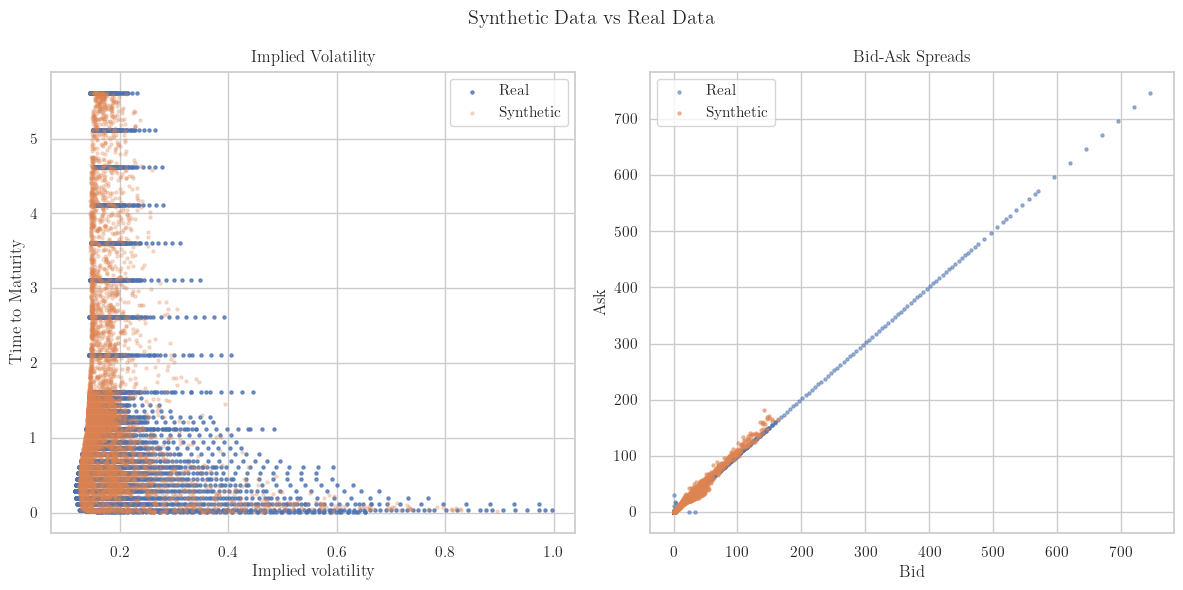

In [332]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the implied volatility against the TTM in the first subplot
axs[0].scatter(df_real['iv'], df_real['TTM'], s=5, alpha=0.75, label="Real")
axs[0].scatter(df_synthetic['iv'], df_synthetic['TTM'], s=5, alpha=0.25, label="Synthetic")
axs[0].set_title("Implied Volatility")
axs[0].set_xlabel("Implied volatility")
axs[0].set_ylabel("Time to Maturity")
axs[0].legend()

# Plot the bid-ask spreads of both the real and simulated data in the second subplot
axs[1].scatter(df_real['bid'], df_real['ask'], s=5, alpha=0.5, label="Real")
axs[1].scatter(df_synthetic['bid'], df_synthetic['ask'], s=5, alpha=0.5, label="Synthetic")
axs[1].set_title("Bid-Ask Spreads")
axs[1].set_xlabel("Bid")
axs[1].set_ylabel("Ask")
axs[1].legend()

# Adjust layout for better display
plt.suptitle('Synthetic Data vs Real Data')
plt.tight_layout()
plt.show()


















### Plot distributions of features

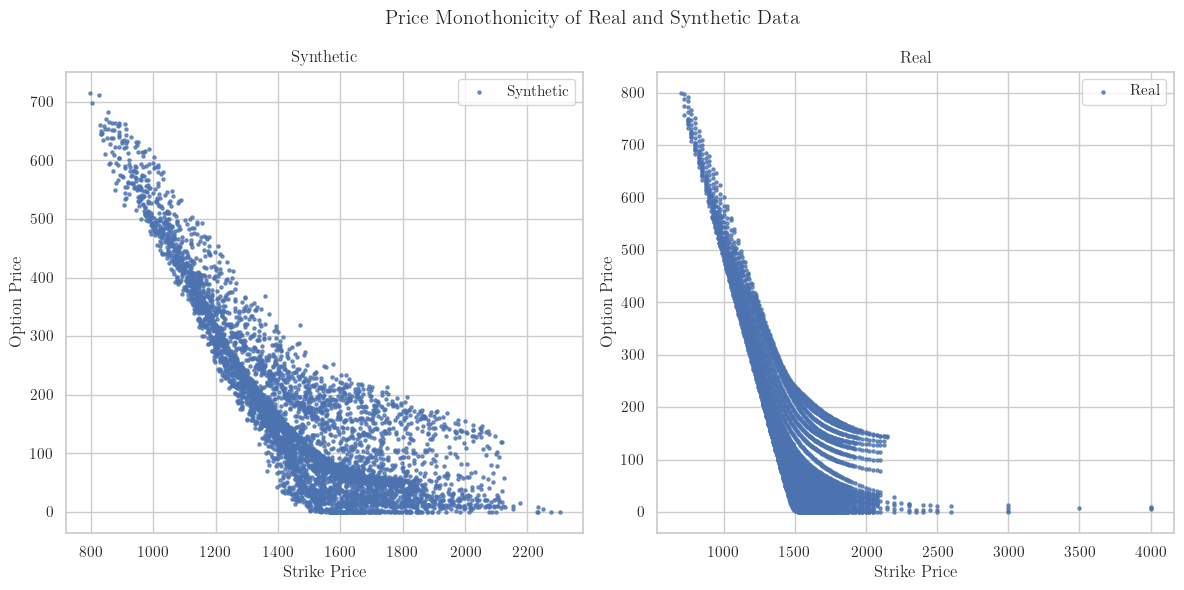

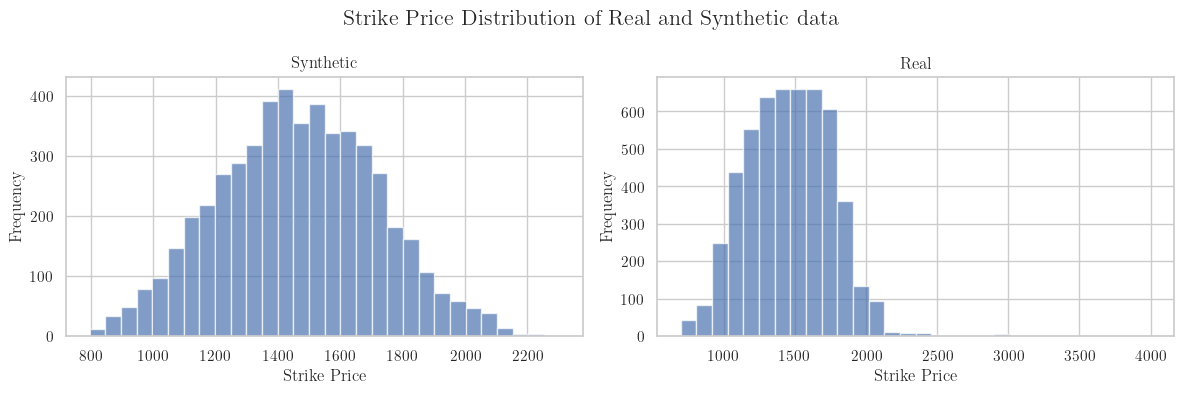

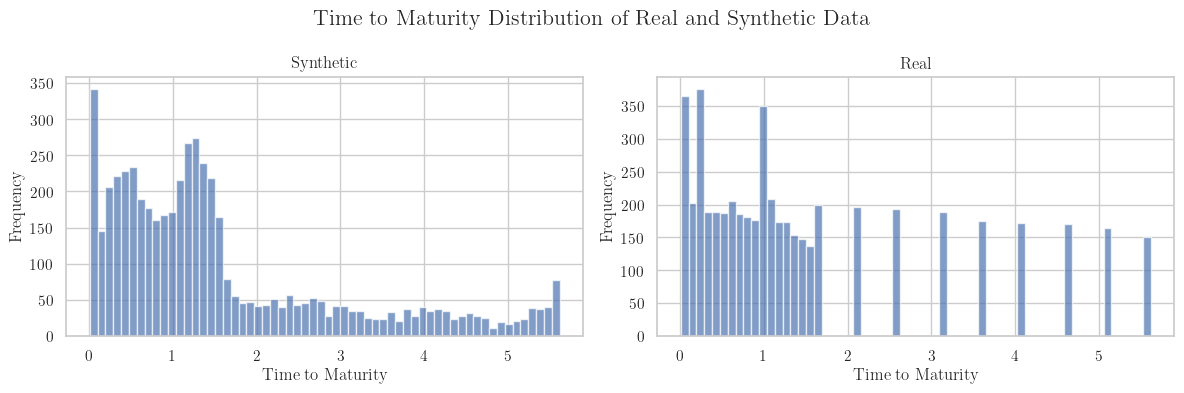

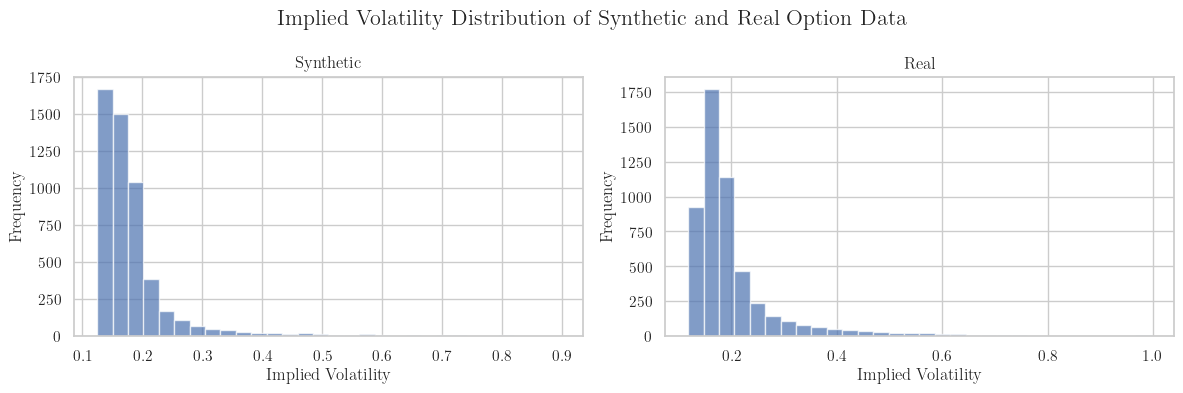

In [333]:
# --------------------------------------------------------------------------------------------------------#
# Plot the price monotonicity of real and synthetic data
# --------------------------------------------------------------------------------------------------------#
# Plot the option price and strike price of real data in the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the option price and strike price of simulated data in the second subplot
axs[0].scatter(df_synthetic['strike'], df_synthetic['settlement'], s=5, alpha=0.75, label="Synthetic")
axs[0].set_title("Synthetic")
axs[0].set_xlabel("Strike Price")
axs[0].set_ylabel("Option Price")
axs[0].legend()

# Plot the option price and strike price of real data in the first subplot
axs[1].scatter(df_real['strike'], df_real['settlement'], s=5, alpha=0.75, label="Real")
axs[1].set_title("Real")
axs[1].set_xlabel("Strike Price")
axs[1].set_ylabel("Option Price")
axs[1].legend()

# Adjust layout for better display
plt.suptitle('Price Monothonicity of Real and Synthetic Data')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------------------------------#
# Plot the strike price distributions
# --------------------------------------------------------------------------------------------------------#
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  
plt.hist(df_synthetic['strike'], bins=30, alpha=0.7)
plt.title('Synthetic')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  
plt.hist(df_real['strike'], bins=30, alpha=0.7)
plt.title('Real')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

fig.suptitle('Strike Price Distribution of Real and Synthetic data', fontsize=16)
plt.tight_layout()  
plt.show()

# --------------------------------------------------------------------------------------------------------#
# Plot the TTM distributions
# --------------------------------------------------------------------------------------------------------#
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  
plt.hist(df_synthetic['TTM'], bins=60, alpha=0.7)
plt.title('Synthetic')
plt.xlabel('Time to Maturity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  
plt.hist(df_real['TTM'], bins=60, alpha=0.7)
plt.title('Real')
plt.xlabel('Time to Maturity')
plt.ylabel('Frequency')

fig.suptitle('Time to Maturity Distribution of Real and Synthetic Data', fontsize=16)
plt.tight_layout()  
plt.show()

# --------------------------------------------------------------------------------------------------------#
# plot the implied volatility distributions
# --------------------------------------------------------------------------------------------------------#
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  
plt.hist(df_synthetic['iv'], bins=30, alpha=0.7)
plt.title('Synthetic')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  
plt.hist(df_real['iv'], bins=30, alpha=0.7)
plt.title('Real')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')

fig.suptitle('Implied Volatility Distribution of Synthetic and Real Option Data', fontsize=16)
plt.tight_layout()  
plt.show()

## Metric 1: Volatility Smiles

### Get the right Time to Maturities

In [334]:
accuracy = 0.5

# Get all time to maturities
ttms = df_synthetic['TTM']

# Create a list with desired time to maturities
target_ttms = np.arange(accuracy, math.ceil(float(max(ttms))), accuracy)

# Round all time to maturities to the nearest accuracy level
df_synthetic['TTM'] = (np.round(df_synthetic['TTM'] / accuracy) * accuracy).astype(float)
df_real['TTM'] = (np.round(df_real['TTM'] / accuracy) * accuracy).astype(float)

# Get all unique time to maturities
unique_ttms = df_synthetic['TTM'].unique()
unique_ttms.sort()


### Plot only the synthetic smiles

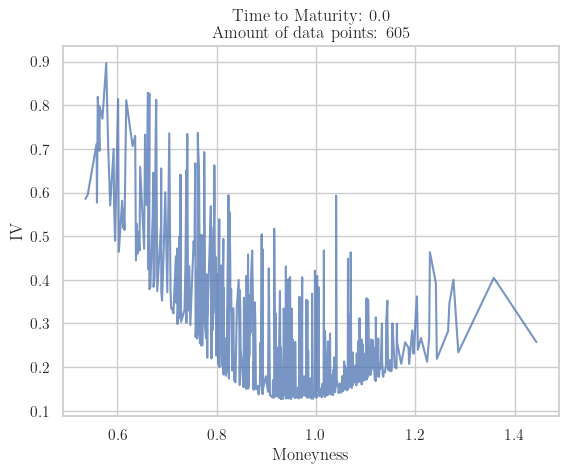

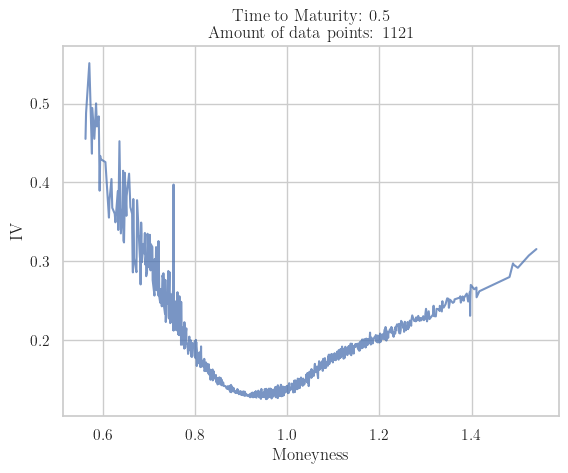

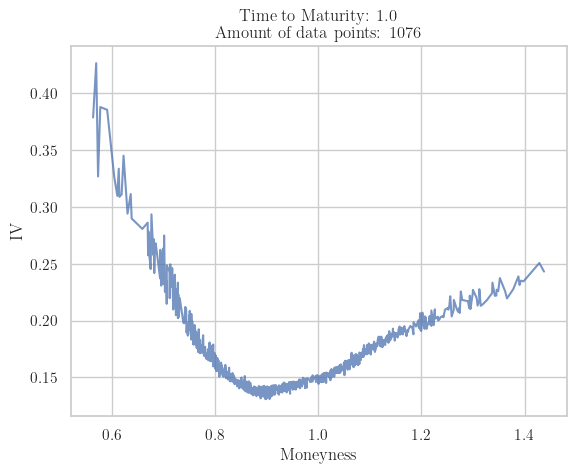

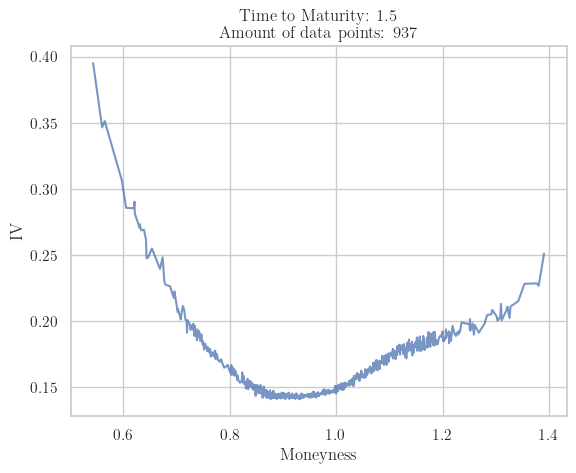

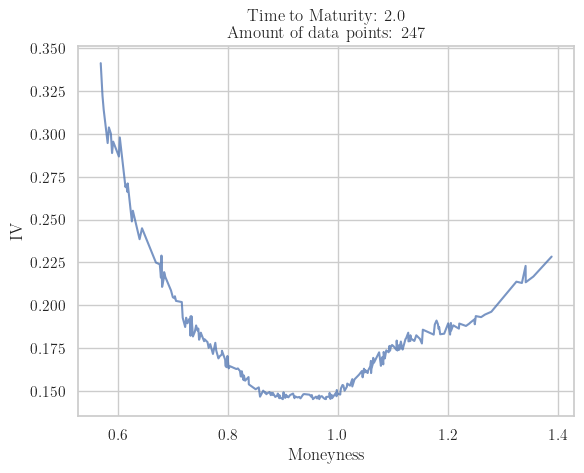

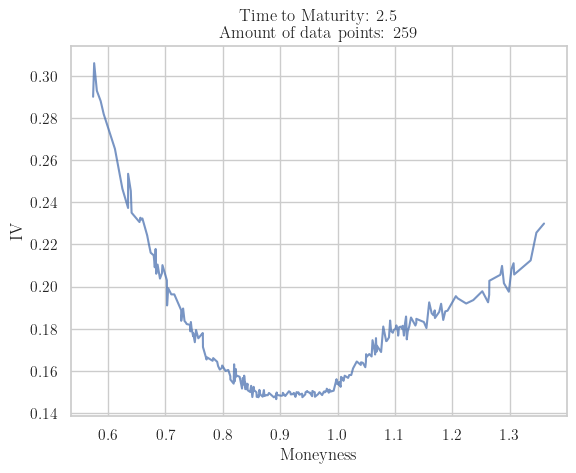

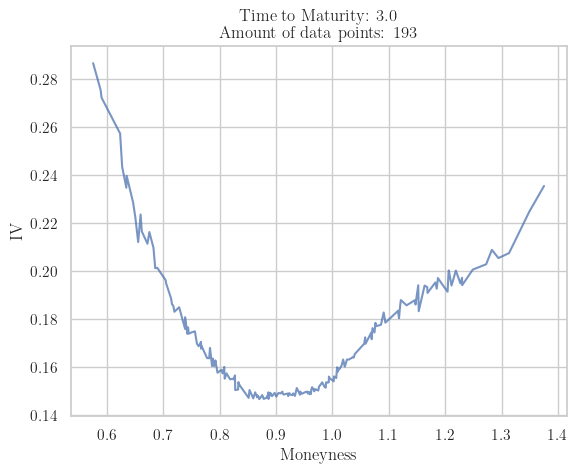

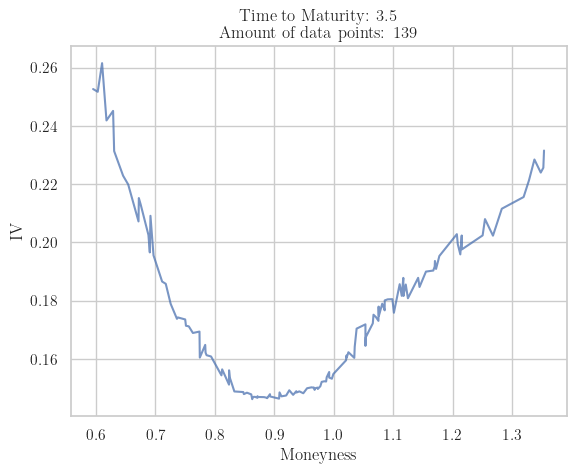

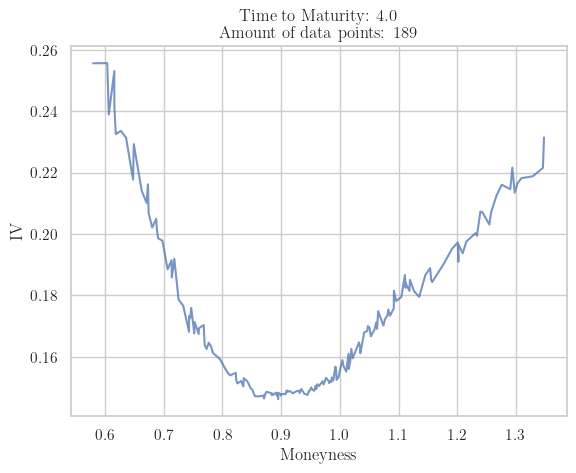

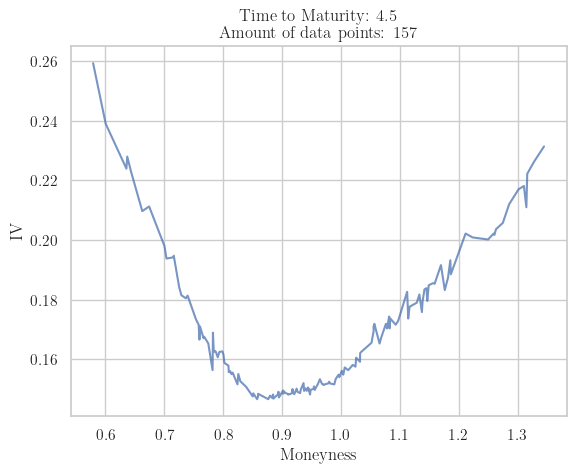

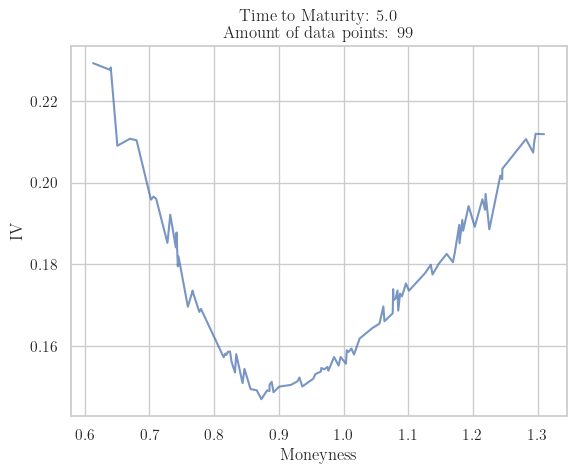

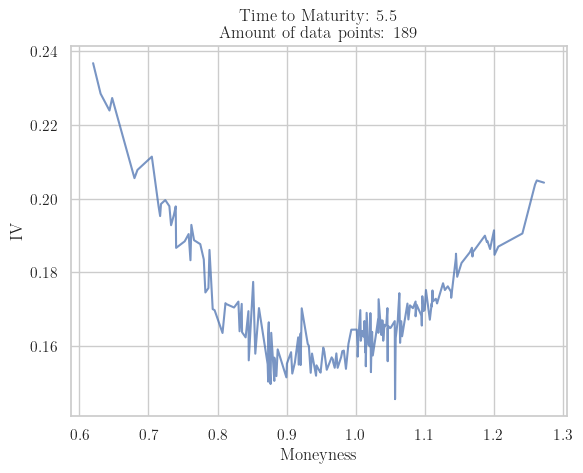

In [335]:
# Plot 'IV' against 'Moneyness' for each 'TTM'
for ttm in unique_ttms:
    # Create a subset of the data for each TTM
    subset = df_synthetic[df_synthetic['TTM'] == ttm]
    subset_sorted = subset.sort_values(by='Moneyness')  
    ttm_count = len(subset_sorted)
    
    # Plot the data
    plt.figure()
    plt.plot(subset_sorted['Moneyness'], subset_sorted['iv'], alpha = 0.75) 
    plt.title(f'Time to Maturity: {ttm.round(4)}\n Amount of data points: {ttm_count}')
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.grid(True) 
    plt.show()  

### Plot the synthetic smiles combined with the real smiles

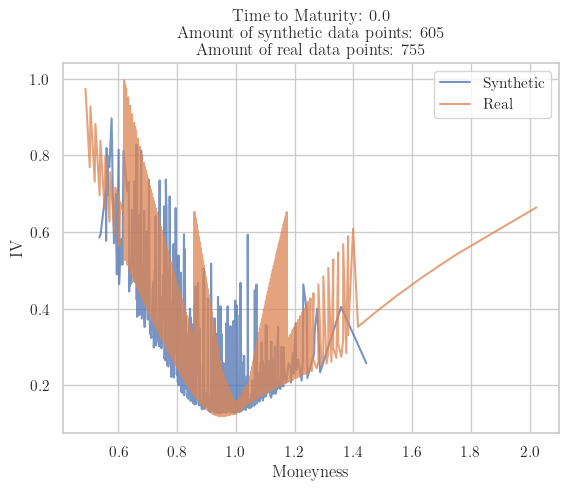

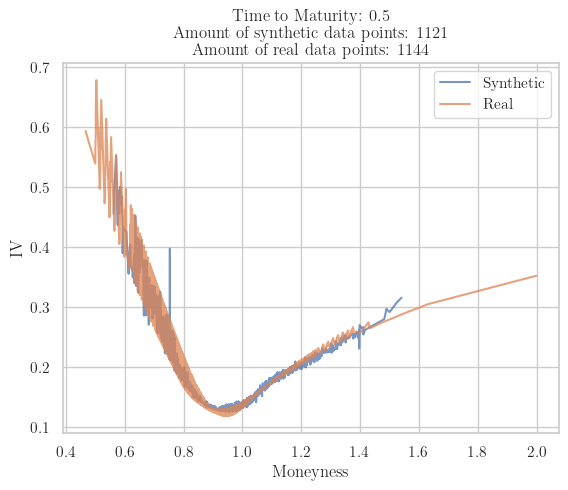

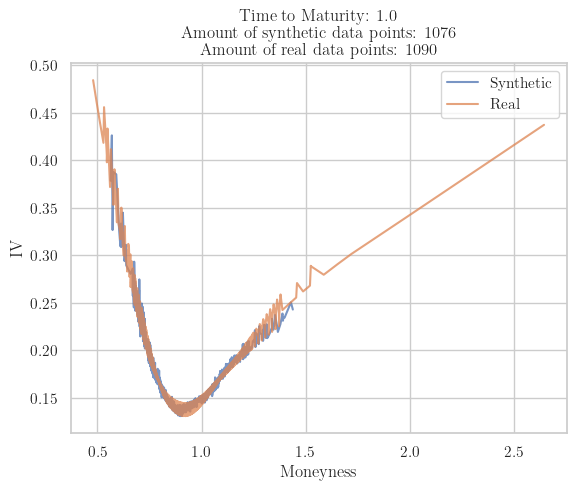

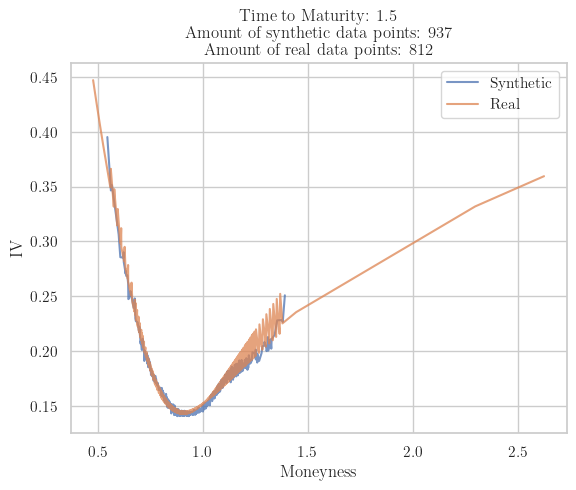

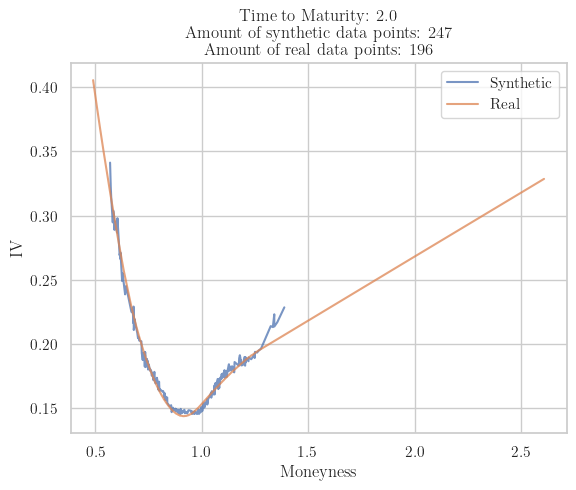

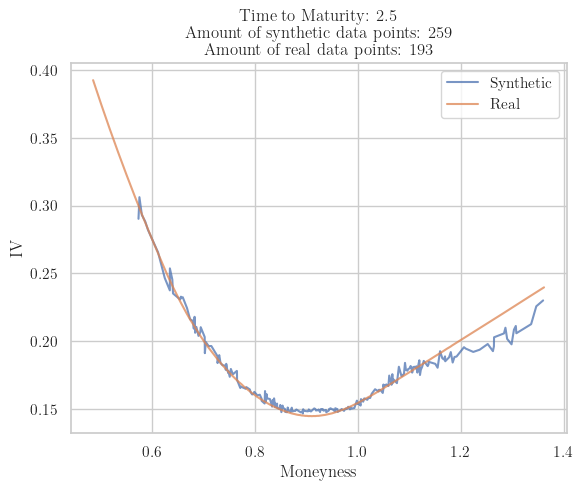

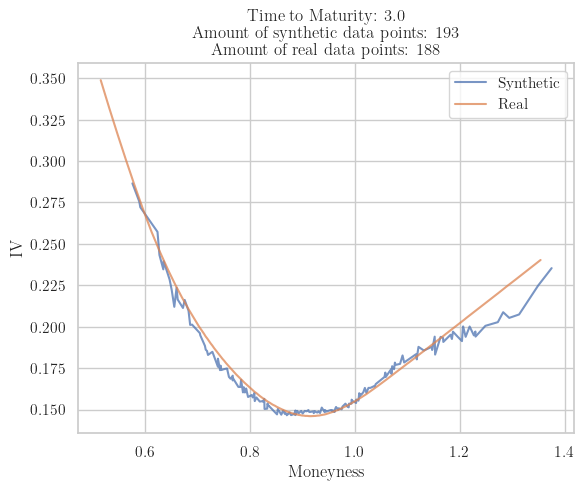

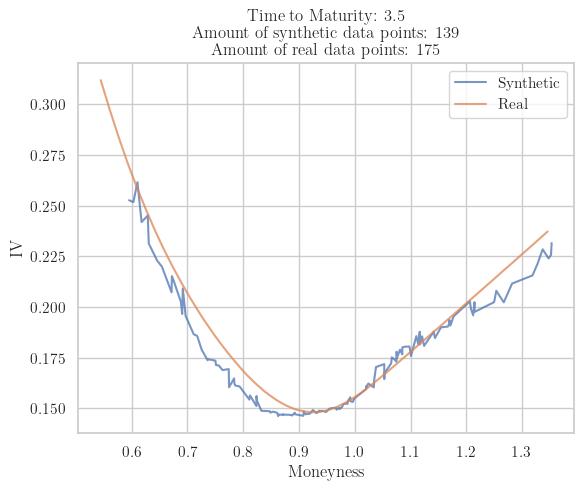

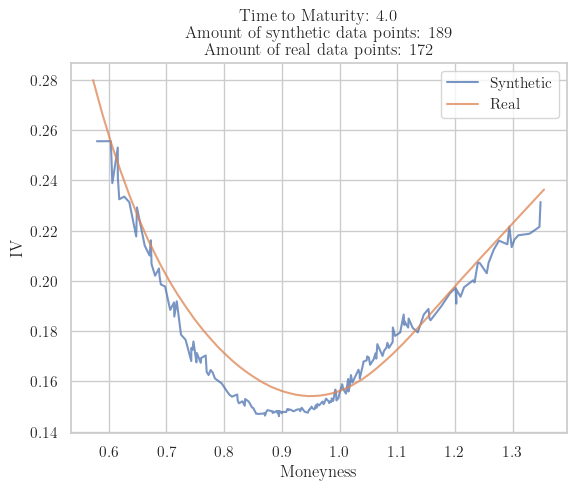

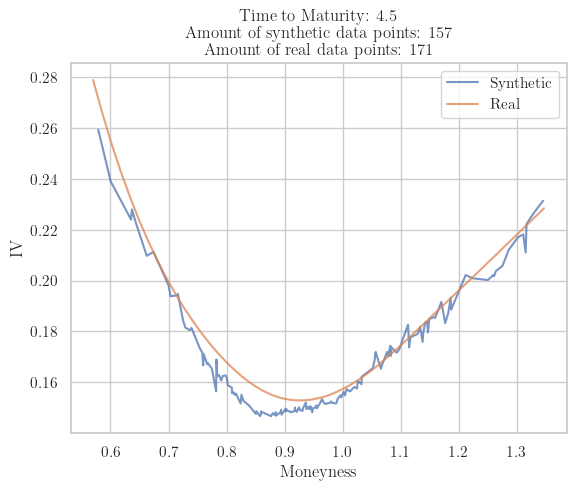

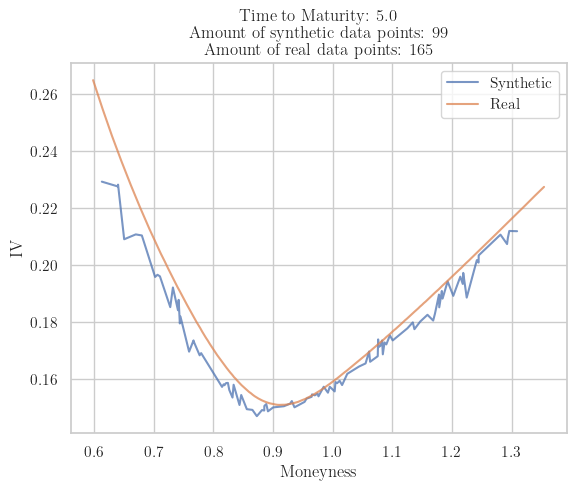

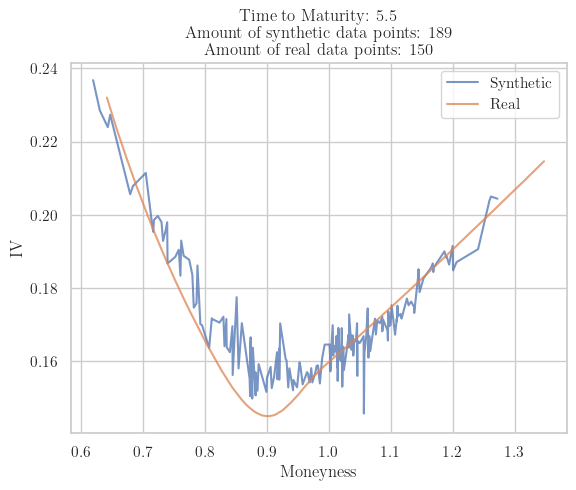

In [336]:
import matplotlib.pyplot as plt


# Plot 'IV' against 'Moneyness' for each 'TTM'
for ttm in unique_ttms:
    # Create a subset of the synthetic data for each TTM
    subset_synthetic = df_synthetic[df_synthetic['TTM'] == ttm]
    subset_synthetic_sorted = subset_synthetic.sort_values(by='Moneyness')
    
    # Create a subset of the real data for each TTM
    subset_real = df_real[df_real['TTM'] == ttm]
    subset_real_sorted = subset_real.sort_values(by='Moneyness')
    
    # Count the number of data points in the subsets
    ttm_count_synthetic = len(subset_synthetic_sorted)
    ttm_count_real = len(subset_real_sorted)
    
    # Plot the synthetic data
    plt.figure()
    plt.plot(subset_synthetic_sorted['Moneyness'], subset_synthetic_sorted['iv'], alpha=0.75, label='Synthetic')
    
    # Plot the real data
    plt.plot(subset_real_sorted['Moneyness'], subset_real_sorted['iv'], alpha=0.75, label='Real')
    
    # Add titles and labels
    plt.title(f'Time to Maturity: {ttm.round(4)}\n'
              f'Amount of synthetic data points: {ttm_count_synthetic}\n'
              f'Amount of real data points: {ttm_count_real}')
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.grid(True)
    plt.legend()  # This adds a legend to distinguish between the real and synthetic data
    plt.show()


## Metric 2: No Arbitrage Conditions

### Bid Ask Spread

For the no arbitrage condition to hold, 

\begin{equation}
Bid < Ask, 
\end{equation}

So we will check in the data if indeed, 

\begin{equation}
Ask - Bid > 0 
\end{equation}

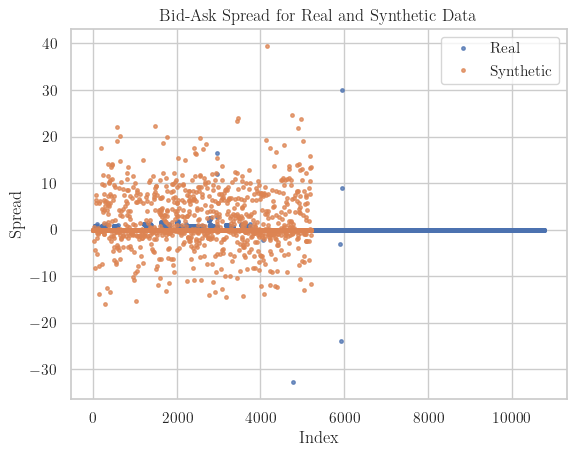

In [337]:
# Compute the bid ask spread in both dataframes
df_real['spread'] = df_real['ask'] - df_real['bid']
df_synthetic['spread'] = df_synthetic['ask'] - df_synthetic['bid']

# Plot spread through time for both real and synthetic data
plt.figure()
plt.plot(df_real['spread'], 'o', markersize = 2.5, alpha=0.75, label='Real')
plt.plot(df_synthetic['spread'],'o', markersize = 2.5, alpha=0.75, label='Synthetic')
plt.title('Bid-Ask Spread for Real and Synthetic Data')
plt.xlabel('Index')
plt.ylabel('Spread')
plt.grid(True)
plt.legend()
plt.show()


In [338]:
# print the lenght of the real and synthetic data
print('Length of real data: ' + str(len(df_real)))
print('Length of synthetic data: ' + str(len(df_synthetic)))

Length of real data: 5211
Length of synthetic data: 5211


### Butterfly Spread


### Put - Call Parity